# Imports

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt
 
import pickle
 
from sklearn.model_selection import KFold
import gc
import numpy as np
#import keras.backend as K
 
import numpy as np
import pandas as pd
import seaborn as sb
import math
 
import os
import re
import glob
 
import tensorflow as tf
from tqdm.notebook import tqdm
 
import torch
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data loading

Regular dataloading. **Do not** use "engine" or "encoding" paramteres if those weren't used to create the csv files.

In [ ]:
train_path = r'/content/drive/MyDrive/FakeNews/FakeNewsDetection Dataset/Stratified K Fold/Training Set'
test_path = r'/content/drive/MyDrive/FakeNews/FakeNewsDetection Dataset/Stratified K Fold/Test Set'
all_train_files = glob.glob(train_path + "/*.csv")
all_test_files = glob.glob(test_path + "/*.csv")

In [ ]:
INDEX = 9
Model_name = "Bert"
# rootPath =  r'/content/drive/MyDrive/SMOTE Results/' +Model_name+ '/Run 1/'
rootPath =  r'/content/drive/MyDrive/FakeNews/SMOTE Results/' +Model_name+ '/Run 1/' #Navid's drive


In [ ]:
df = pd.read_csv(all_train_files[INDEX],encoding='utf-8')
print(df['Label'].count())

df1 = pd.read_csv(all_test_files[INDEX],encoding='utf-8')
print(df1['Label'].count())

2869
318


In [ ]:
# # Detect hardware, return appropriate distribution strategy
# try:
#     # TPU detection. No parameters necessary if TPU_NAME environment variable is
#     # set: this is always the case on Kaggle.
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
# if False:
#   import torch_xla
#   import torch_xla.core.xla_model as xm

Here, data has been split. Ofc this wouldn't be needed. After loading the csv files, this is where code for stratification will go, ergo, the dataset will be split into k-fold right here. The following chunk of code can be replaced.

**The dataframes must be converted to lists. Because the tokenizer expects them to be in a python-list format.**

In [ ]:
train_texts=[]
train_labels= []
test_texts=[]
test_labels = []
for i in range(0, len(all_train_files)):
  train_file = pd.read_csv(all_train_files[i],encoding='utf-8')
  test_file = pd.read_csv(all_test_files[i],encoding='utf-8')
  train_texts.append(train_file['Description'].tolist())
  train_labels.append(train_file['Label'].tolist())
  test_texts.append(test_file['Description'].tolist())
  test_labels.append(test_file['Label'].tolist())

In [ ]:
print(len(train_texts[INDEX]))
print(len(test_texts[INDEX]))
print(len(train_labels[INDEX]))
print(len(test_labels[INDEX]))

2869
318
2869
318


# Generating Embedding 

Tokenizer is being loaded. It is recommended that we use the tokenizer corresponding to the model we would use for both embedding generation and classfication.

In [ ]:
from transformers import BertTokenizerFast, BertTokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

train_encodings = tokenizer(train_texts[INDEX], truncation=True, padding='max_length' ,return_tensors="pt")
test_encodings = tokenizer(test_texts[INDEX], truncation=True, padding='max_length' ,return_tensors="pt")



All the texts in all the sets will tokenized here. These encodings simply refer to tokens.

In [ ]:
# if False:
#   train_encodings=[]
#   test_encodings=[]
#   for i in range(0,len(train_texts)):
#     train_encodings.append(tokenizer(train_texts[i], truncation=True, padding='max_length' ,return_tensors="pt"))
#     # val_encodings = tokenizer(val_texts, truncation=True, padding='max_length' ,return_tensors="pt")
#     test_encodings.append(tokenizer(test_texts[i], truncation=True, padding='max_length' ,return_tensors="pt"))

In [ ]:
# if False:
#   print("train encodings length: ",len(train_encodings))
#   print(test_encodings['input_ids'][0])
#   # # print("val_encodings length: ",len(val_encodings))
#   # print("test_encodings length: ",len(test_encodings[0])) 

You can run this for sanity check. Especially, the function tokenizer_decode(), decodes the tokens back to a whole sentence. Decoding has been done for one set (corresponding to one sentence) of tokens.

In [ ]:
# if False:
#   # print(train_encodings)
#   print(train_encodings[0].ids,"\n",train_encodings[0].ids.count(0))
#   # print(train_encodings[0].type_ids) # whole bunch of zeros
#   print(train_encodings[0].tokens)
#   print(train_encodings[0].attention_mask,"\n",train_encodings[0].attention_mask.count(0))
#   print(train_encodings[0].special_tokens_mask,"\n",train_encodings[0].special_tokens_mask.count(1))
#   print(tokenizer.decode(train_encodings[0].ids))

In [ ]:
# #clears RAM
# if False:
#   torch.cuda.empty_cache()
  

The following model is loaded to create embeddings from the **train dataset only**. 

In [ ]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-multilingual-cased',output_hidden_states=True)


class FakeNewsEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
 
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
 
    def __len__(self):
        return len(self.encodings['input_ids'])

train_embDataset = FakeNewsEmbeddingDataset(train_encodings)
train_dataloader = DataLoader(train_embDataset, batch_size=8)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The following subclass of Dataset will only make use of train_dataset and convert it into a form the model can ingest.

In [ ]:
# if False:
#   train_embDataset = []
#   for i in range(0,len(train_encodings)):
#     train_embDataset.append(FakeNewsEmbeddingDataset(train_encodings[i]))

Initialize a dataloader, which will take in the **train_embDataset** make batches of data out of it.

In [ ]:
# if False:
#   train_dataloader=[]
#   for i in range(0,len(train_embDataset)):
#     train_dataloader.append(DataLoader(train_embDataset[i], batch_size=8))

Here the BERT model converts the **train dataset** into embeddings. Embeddings are of shape (batch_size, max_sequence_length=512, 768=the embedding size of each input token). For details refer to this [link](https://huggingface.co/transformers/model_doc/bert.html).

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = xm.xla_device()
# torch.cuda.empty_cache()
model.to(device)
model.eval()
outputs_list = []
lastLayerEmbeddingList = []
idx = 0
 
for batch in train_dataloader:
      print("batch no: ",idx)
      idx += 1
      batch = {k: v.to(device) for k, v in batch.items()}
      # batch = {k: v for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)
          #lastLayerEmbeddingList[i].append(outputs)
          outputs_list.append(outputs[0].to(torch.float16))
          
#print("batch no: ",idx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


batch no:  0
batch no:  1
batch no:  2
batch no:  3
batch no:  4
batch no:  5
batch no:  6
batch no:  7
batch no:  8
batch no:  9
batch no:  10
batch no:  11
batch no:  12
batch no:  13
batch no:  14
batch no:  15
batch no:  16
batch no:  17
batch no:  18
batch no:  19
batch no:  20
batch no:  21
batch no:  22
batch no:  23
batch no:  24
batch no:  25
batch no:  26
batch no:  27
batch no:  28
batch no:  29
batch no:  30
batch no:  31
batch no:  32
batch no:  33
batch no:  34
batch no:  35
batch no:  36
batch no:  37
batch no:  38
batch no:  39
batch no:  40
batch no:  41
batch no:  42
batch no:  43
batch no:  44
batch no:  45
batch no:  46
batch no:  47
batch no:  48
batch no:  49
batch no:  50
batch no:  51
batch no:  52
batch no:  53
batch no:  54
batch no:  55
batch no:  56
batch no:  57
batch no:  58
batch no:  59
batch no:  60
batch no:  61
batch no:  62
batch no:  63
batch no:  64
batch no:  65
batch no:  66
batch no:  67
batch no:  68
batch no:  69
batch no:  70
batch no:  71
ba

In [ ]:
import sys
print(len(outputs_list))
# print(outputs_list[0].shape)
# print(outputs_list[358])
# print(outputs_list[0].type())
# print(sys.getsizeof(outputs_list[0].storage())*len(outputs_list))

359


The two cells above create a list of tensors. The length of list is the same as the number of batches. If there were 8 batches in total and there were 32 sentences per batch, the length of list would be 8. Furthermore, each tensor in the list would of shape (32,512,768)

The following code turn a list of tensors into one consolidated tensor which would be fed to the classification model.

In [ ]:
#outputTensor = torch.empty((358*8+4,512,768))
#temp = np.empty((2868,512,768))
 
def listToTensor(outputs_list, tensorFirstDim):
  tensorIdx = 0
  outputTensor = torch.zeros(tensorFirstDim,512,768).to(torch.float16)
  for tensor in outputs_list:
    outputTensor[tensorIdx:tensorIdx+tensor.shape[0],:,:] = tensor
    tensorIdx += tensor.shape[0]
  return outputTensor
 
# def listToTensorV2(listOfTensors, firstDim):
#   tensorIdx = 0
#   listIdx = 0
#   outputTensor = torch.zeros(firstDim,512,768).to(torch.float16)
#   for t in listOfTensors:
#     outputTensor[tensorIdx:tensorIdx+t.shape[0],:,:] = t
#     listOfTensors[listIdx] = None
#     listIdx+=1
#     tensorIdx+=t.shape[0]
#   return outputTensor

In [ ]:
outputTensor = listToTensor(outputs_list, len(train_texts[INDEX]))
del outputs_list

In [ ]:
import sys
print(sys.getsizeof(outputTensor.storage()))
print(outputTensor.shape)
outputTensor.type()

2256273480
torch.Size([2869, 512, 768])


'torch.HalfTensor'

In [ ]:
del train_encodings, train_embDataset, train_dataloader,outputs, model, tokenizer

In [ ]:
outputTensor[2866]

tensor([[ 0.1057, -0.0529,  0.2419,  ..., -0.2126,  0.0395, -0.2335],
        [-0.3027, -0.0263,  0.4280,  ...,  1.1992,  0.3176, -0.2690],
        [-0.4417, -0.2625,  0.1943,  ...,  0.4446,  0.9346, -0.1545],
        ...,
        [-0.2074,  0.0918, -0.1515,  ...,  0.0804,  0.6055, -0.0799],
        [-0.2009,  0.0111,  0.7041,  ...,  0.8159,  0.3474, -0.3684],
        [ 0.2411,  0.4619,  0.6484,  ...,  0.1217,  0.2546, -0.2861]],
       dtype=torch.float16)

# SMOTE

In [ ]:
outputTensor = tf.reshape(outputTensor, [len(train_texts[INDEX]),-1])

In [ ]:
print(outputTensor.shape)
print(outputTensor[0][0:100])
# print(outputTensor.type)
print(sys.getsizeof(train_labels[INDEX])*len(train_labels))

(2869, 393216)
tf.Tensor(
[-0.0029    0.2484   -0.09784  -0.1011    0.375    -0.2017   -0.04605
 -0.11786   0.03053   0.04465  -0.2012   -0.1265    0.0524    0.117
 -0.689    -0.04266  -0.09534   0.1255    0.2227    0.2783    0.1149
 -0.04446   0.02808   0.1611    0.00579   0.00821   0.0718    0.5405
  0.7905    0.3162    0.2078    0.08466  -0.1892   -0.2288    0.06067
 -0.3323   -1.704     0.0447   -0.0717    0.1243    0.02661  -0.002937
 -0.04343  -0.0879    0.2664    1.08      0.0498    0.181     1.105
  0.0973    0.05725  -0.758    -0.03738  -1.459     0.206    -0.03235
  0.02953  -0.1149   -0.1145    0.0762    0.1357    0.3296    0.1267
 -0.11694  -0.2477    0.09644   0.0846    0.1827   -0.1255    0.1415
  0.1996    0.0698   -0.05765  -0.225     0.141     0.215     0.1329
  0.2217   -0.01283  -0.173     0.01505   0.06396  -0.423    -0.01375
  0.0495   -0.067    -0.05182  -0.1418    0.05304   0.2957   -0.257
  0.0415   -0.4446   -0.01313  -0.1844   -0.9023    0.1986   -0.0288
  0.1

In [ ]:
outputTensor = outputTensor.numpy()
y = np.array(train_labels[INDEX])

In [ ]:
import sys
sys.getsizeof(y)

23048

In [ ]:
from imblearn.over_sampling import SMOTE

smoteBatchSize = 200
oversample = SMOTE(k_neighbors=5, random_state=42)
smoteTensorList = []
y_list = []
idx=0
for i in range(0, outputTensor.shape[0]//smoteBatchSize+1):
  print("iter: ",i)
  temp1 = None
  temp2 = None
  if y.shape[0]>=smoteBatchSize:
    temp1, temp2 = oversample.fit_resample(outputTensor[0:smoteBatchSize,:],y[0:smoteBatchSize])
    outputTensor = outputTensor[smoteBatchSize:,:]
    y = y[smoteBatchSize:]
  else:
    temp1, temp2 = oversample.fit_resample(outputTensor[0:,:],y[0:])
    del outputTensor
    del y
  smoteTensorList.append(temp1)
  y_list.append(temp2)
  
  # idx+=500

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


iter:  0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  3


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  7


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  8


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  9


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  10


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  11


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  12


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  13


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


iter:  14


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(len(y_list))
print(len(smoteTensorList))
print(len(y_list[0]),"\n",len(y_list[-1]))
print(smoteTensorList[1].shape,"\n",smoteTensorList[-1].shape)
print(len(smoteTensorList[1]))

15
15
322 
 114
(310, 393216) 
 (114, 393216)
310


In [ ]:
def embeddingSize(listOfArray):
  retSize = 0
  for t in listOfArray:
    retSize += t.shape[0]
  return retSize

In [ ]:
smoteDatasize = embeddingSize(smoteTensorList)
print(smoteDatasize)
print(sys.getsizeof(None))

4656
16


In [ ]:
# if False:
#   smoteTensor = listToTensorV2(smoteTensorList,smoteDatasize)

#Classification Model

In [ ]:
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, datasetType):
        self.encodings = encodings
        self.labels = labels
        self.datasetType = datasetType

    def __getitem__(self, idx):
        item = {}
        if self.datasetType == "train":
          item['inputs_embeds'] = self.encodings[idx]
        else:
          item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Once again we use a subclass of Dataset class (FakeNewsDataset) to create final datasets we need for each step of k-fold cross validation. To create **train_dataset**, we use the embeddings we computed just now. To create the **test_dataset**, the list of sentences created by applying "tolist()" on the dataframe containing test split is used.

In [ ]:
print(smoteTensorList[0].shape)
for idx in range(0,len(smoteTensorList)):
  smoteTensorList[idx] = smoteTensorList[idx].reshape(-1,512,768)
print(smoteTensorList[0].shape)

(322, 393216)
(322, 512, 768)


In [ ]:
sum = 0
for i in range(0,len(smoteTensorList)):
  sum += math.ceil(len(smoteTensorList[i])/8)
print(sum*15)

8835


In [ ]:
from torch.utils.data import DataLoader
from transformers import get_scheduler
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AdamW

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")
optimizer = AdamW(model.parameters(), lr=4e-5)


model.to(device)

num_epochs = 15
batch_size = 8
sum = 0
Loss = []

sum = 0
steps = 0
for i in range(0,len(smoteTensorList)):
  sum += math.ceil(len(smoteTensorList[i])/batch_size)

num_training_steps = num_epochs * sum
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

model.train()


for epoch in range(num_epochs):
  print("Epoch No", epoch)
  for i in range(len(smoteTensorList)):
    print("Tensor", i)
    train_dataloader = DataLoader(FakeNewsDataset(smoteTensorList[i],y_list[i],"train"), shuffle=True, batch_size=8)
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        steps+=1
        loss = outputs.loss
        loss.backward()
        if(steps%100==0):
          Loss.append(loss)
        

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch No 0
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 1
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 2
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 3
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 4
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 5
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Tensor 9
Tensor 10
Tensor 11
Tensor 12
Tensor 13
Tensor 14
Epoch No 6
Tensor 0
Tensor 1
Tensor 2
Tensor 3
Tensor 4
Tensor 5
Tensor 6
Tensor 7
Tensor 8
Te

In [ ]:
print(len(Loss))
for i in range(len(Loss)):
  print(Loss[i].item())

88
0.5125631093978882
0.3844442069530487
0.16606645286083221
0.1536693125963211
0.7591034173965454
0.7475364208221436
0.7191165089607239
0.35846468806266785
0.708942174911499
0.7711504101753235
0.6475796699523926
0.6981186270713806
0.4806784987449646
0.21185651421546936
0.6638472676277161
0.6448787450790405
0.5120536088943481
0.6589515209197998
0.2192464917898178
0.7466031312942505
0.6195812821388245
0.6738947033882141
0.6524918675422668
0.7213727235794067
0.7600733041763306
0.7035809755325317
0.6999799609184265
0.697091281414032
0.6421486139297485
0.6929662227630615
0.692736029624939
0.6843032240867615
0.7109264135360718
0.5963103771209717
0.7071799635887146
0.6813439130783081
0.7005395293235779
0.7063772082328796
0.6777975559234619
0.6924067735671997
0.6922662258148193
0.7203551530838013
0.5216459631919861
0.7282994985580444
0.6934970617294312
0.6674129366874695
0.6891384720802307
0.6875491738319397
0.6850971579551697
0.689349889755249
0.691971480846405
0.6773006916046143
0.689034044

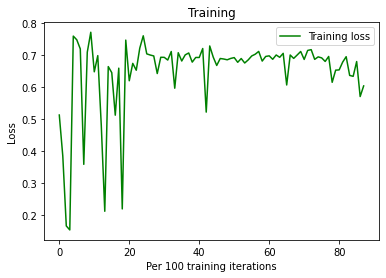

In [ ]:
import matplotlib.pyplot as plt
 
lossDataPointNum = range(0,len(Loss))
plt.plot(lossDataPointNum, Loss[0:], 'g', label='Training loss')

plt.title('Training')
plt.xlabel('Per 100 training iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig(rootPath+'/train_loss_'+str(INDEX)+'.png')
plt.show()

In [ ]:
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments
# Model_name = 'Bert'
# epoches = 15

# training_args = TrainingArguments(
#     output_dir='/content/drive/MyDrive/SMOTE Results/' + Model_name  +   '/Output' +'/Fold' + str(INDEX),  # output directory
#     load_best_model_at_end  = True,   # loads the best model for testing 
#     metric_for_best_model = "training_loss",
#     greater_is_better = False,     
#     num_train_epochs=1,              # total number of training epochs
#     per_device_train_batch_size=8,  # batch size per device during training
#     per_device_eval_batch_size=8,   # batch size for evaluation
#     # warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='/content/drive/MyDrive/SMOTE Results/' + Model_name +  '/Logs'  + '/Fold' + str(INDEX) ,            # directory for storing logs
#     logging_steps=10,
#     fp16 = True,
#     learning_rate= 4e-5,
#     lr_scheduler_type = "linear",
#     warmup_ratio = 0.06,
#     save_strategy= "no",
# )

# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")
# model.to(device)

# returns = []
# for i in range(epoches):
#   print("Epoch", i)

#   for idx in range(0, len(smoteTensorList)):
    
#     print("Iteration",idx)
#     train_dataset = FakeNewsDataset(smoteTensorList[idx],y_list[idx],"train")
#     trainer = Trainer(
#       model=model,                         # the instantiated 🤗 Transformers model to be trained
#       args=training_args,                  # training arguments, defined above
#       train_dataset=train_dataset,         # training dataset
#       # eval_dataset=val_dataset             # evaluation dataset
#     )
#     returns.append(trainer.train())

In [ ]:
# print(len(returns))
# print(returns)
# train_loss = []
# for i in range(0,len(returns)):
#   train_loss.append(returns[i][1])
# print(train_loss)

In [ ]:
print(len(test_labels[INDEX]))
# print(test_encodings)
print(test_encodings['input_ids'].shape)
print(test_encodings['attention_mask'].shape)


318
torch.Size([318, 512])
torch.Size([318, 512])


In [ ]:
model.eval()
statsList = []
test_dataset = FakeNewsDataset(test_encodings,test_labels[INDEX],"test")
test_dataloader = DataLoader(test_dataset, batch_size=16)
idx = 0
for batch in test_dataloader:
      # print("batch no: ",idx)
      idx += 1
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)
          statsList.append(outputs.logits)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [ ]:
resultList = []
tempList = []
for stat in statsList:
  tempList.append(stat.argmax(dim=1))
for l in tempList:
  for label in l:
    resultList.append(label)
del tempList 

In [ ]:
r=[]
for i in range(0,len(resultList)):
  r.append(resultList[i].tolist()) 

In [ ]:
print(r)
print(resultList)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor(1, device='cuda:0'), tensor(1, device

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score
acc = accuracy_score(test_labels[INDEX],r)
recall = recall_score(test_labels[INDEX],r)
f1 = f1_score(test_labels[INDEX],r)
precision = precision_score(test_labels[INDEX],r)
tn, fp, fn, tp = confusion_matrix(test_labels[INDEX],r).reshape(-1)

In [ ]:
print(acc)
print(recall)
print(f1)
print(precision)
print(tp, fn, fp, tn)


0.8113207547169812
1.0
0.8958333333333334
0.8113207547169812
258 0 60 0


In [ ]:
pickle.dump(model, open(rootPath + 'Models/' + Model_name + str(INDEX)+'.pkl', 'wb'))

In [ ]:
# if INDEX == 0:
#   df = pd.read_csv(rootPath + 'Init.csv',encoding='utf-8')

df = pd.read_csv(rootPath +  Model_name +  'Result.csv',encoding='utf-8')

print(df)

data = {'Fold No': str(INDEX), 'Accuracy':acc, 'Recall':recall, 'Precision':precision, 'F1_Score':f1,
          'TP':tp, 'TN':tn, 'FP':fp, 'FN':fn }

df=df.append(data,ignore_index=True,sort=False)
print(df)


df.to_csv(rootPath + Model_name +   'Result.csv', index=False, encoding='utf-8')


   Fold No  Accuracy    Recall  Precision  F1_Score   TP  TN  FP   FN
0        0  0.811912  1.000000   0.811912  0.896194  259   0  60    0
1        1  0.191223  0.034749   0.529412  0.065217    9  52   8  250
2        2  0.188088  0.000000   0.000000  0.000000    0  60   0  259
  Fold No  Accuracy    Recall  Precision  F1_Score   TP  TN  FP   FN
0       0  0.811912  1.000000   0.811912  0.896194  259   0  60    0
1       1  0.191223  0.034749   0.529412  0.065217    9  52   8  250
2       2  0.188088  0.000000   0.000000  0.000000    0  60   0  259
3       9  0.811321  1.000000   0.811321  0.895833  258   0  60    0
